# Connectivity Constraint in Meep adjoint

For manufacturability, connectivity constraint is often desired. This is a simple tutorial example of the connectivity constraint in Meep adjoint. This feature is rather independent and may be used alone, when applicable.

In [1]:
import meep.adjoint as mpa
import numpy as np
from scipy.sparse.linalg import cg, spsolve
from matplotlib import pyplot as plt

Using MPI version 3.1, 1 processes


The underlying idea (based on Li, Q. et al. https://doi.org/10.1007/s00158-016-1459-5) is briefly summerized below:

Consider the heat equation, and regard the material as heat conductive and void as heat insulative. Solving the heat equation, we should expect the heat gets diffused into the connected component but not the disconnected component.
In practice, 3D-printed structure is often mounted on some substrate. This means the optimized structure should be connected to one side. For our heat equation, we impose Dirichlet boundary condition ($T=T_0$) on one side, (and Neumann on other sides,) the resulting temperature should be almost $T_0$ for all structures connected to that side. The p-norm weighted by material density $(\frac{\sum (T-T_0)^p \rho}{\sum \rho})^\frac1{p}$ measures how well the structure is connected. 

Additionally, damping terms are added so the heat can quickly decay away outside the material. The equation solved is thus $(-\nabla \cdot(k \nabla) + \alpha^2 (1-\rho)k + \alpha_0^2)T=0.$, where the conductivity $k=\rho k_0$ for material density $\rho \in [0,1]$

The solver assumes the side with Dirichlet boundary condition is the last slice ``rho[-nx*ny:]``. For 2D, as in the following example below, set ``ny=1``. In Meep, if we want the structure connect to the bottom, we can use ``rot90`` before we pass in. 

foward value 0.6369810999723368


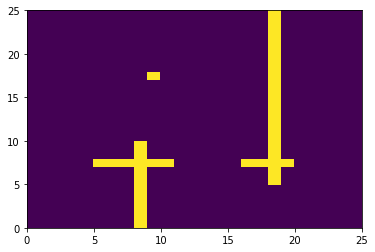

In [6]:
nz, ny, nx =25, 1, 25
c = mpa.ConnectivityConstraint(nx, ny, nz,sp_solver=cg)

r = np.zeros((nz, ny,nx))+0.0001
r[:10,0, 8]=0.999
r[7,0,5:20]=0.999
r[5:,0, 18]=0.999
r[7,0,11:16]=0.0001
r[17:18,0,9:10]=0.999

r=r.flatten()#flatten the structure before pass in
f = c.forward(r)
ag = c.calculate_grad()

print("foward value", f) 

plt.figure()
plt.pcolormesh(r.reshape((nz, nx)))
plt.show()


The above structure has the following temperature distribution. As expected, component connected to the top (where Dirichlet BC is enforeced) has high value of temperature.

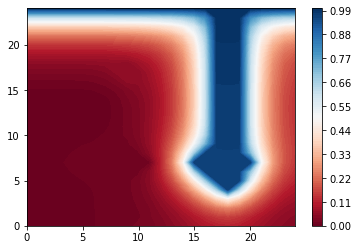

In [7]:
#padding to show the side with Dirichlet BC
fullT = np.pad(c.T, (0, c.nx*c.ny), 'constant', constant_values=1).reshape((nz, ny, nx)) 
plt.figure()
plt.contourf(fullT[:,0,:], 100, cmap="RdBu")
plt.colorbar()
plt.show()

The gradient across the structure is shown below. Note the part that can bridges one disconncted component to connected one has negative gradient. One the other hand, the island in the upper left corner has postive gradient itself, but also tries to connect to the top and right where the gradient is negative.

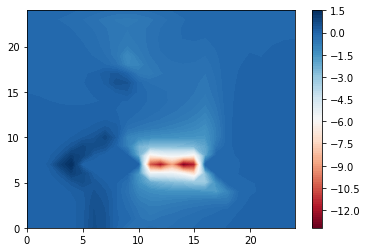

In [8]:
plt.figure()
plt.contourf(ag.reshape((nz, nx)), 100, cmap="RdBu")
plt.colorbar()
plt.show()

For connected structure

foward value 0.06833918047665405


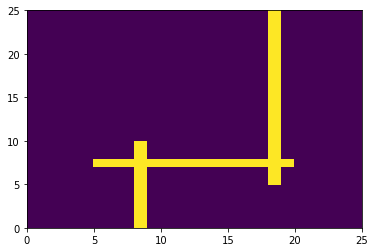

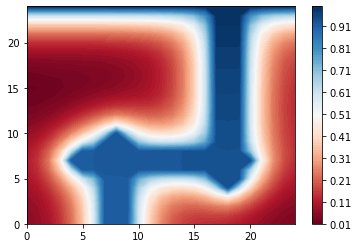

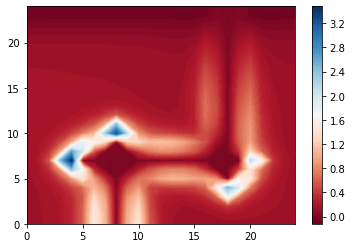

In [5]:
r = np.zeros((nz, ny,nx))+0.0001
r[:10,0, 8]=0.999
r[7,0,5:20]=0.999
r[5:,0, 18]=0.999

r=r.flatten()#flatten the structure before pass in
f = c.forward(r)
ag = c.calculate_grad()

print("foward value", f) 

plt.figure()
plt.pcolormesh(r.reshape((nz, nx)))
plt.show()

fullT = np.pad(c.T, (0, c.nx*c.ny), 'constant', constant_values=1).reshape((nz, ny, nx)) 
plt.figure()
plt.contourf(fullT[:,0,:], 100,cmap="RdBu")
plt.colorbar()
plt.show()

plt.figure()
plt.contourf(ag.reshape((nz, nx)), 100,cmap="RdBu")
plt.colorbar()
plt.show()